<a href="https://colab.research.google.com/github/ValeraKayumov/project/blob/main/Valera_Kayumov_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Тема: анализ продления ежемесячной подписки на музыкальную платформу**

Всем привет! Меня зовут Каюмов Валерий, я выпускник института управления, экономики и финансов Казанского Федерального Университета (КФУ). Работаю продуктовым аналитиком в сфере онлайн образования. Рабочие задачи и натолкнули меня на идею проекта. Однако речь пойдет совсем не про образовательную сферу\
Для связи со мной: \
KayumovValera@gmail.com \
https://t.me/Valera_Kayumov

**Дано:**\
Есть платформа по прослушиванию музыки "Звук". На ней клиенты ежемесячно продлевают свою подписку. В компании всем известно, что в среднем продлевается 85-95% подписок из месяца в месяц. В рамках данного проекта будем работать с сентябрем и октябрем. В прошлом году 90% клиентов сентября продлили свою подписку на октябрь, возьмем прошлый год просто для сравнения с этим и будем иногда к нему обращаться. В этом году с сентября на октябрь перешло всего 70% клиентов. \
**Найти:**\
Почему продления с сентября на октябрь в 2022 году оказались на 20% меньше, чем стандартная средняя величина процента продлений в компании (90%)?

PS. Местами данные могут показаться несопоставимыми с реальной жизнью, и это будет действительно так. Все значения подобраны абсолютно случайно. Целью не является прийти к реальным жизненным выводам. Задача выполняется исключительно в рамках выдуманных данных параллельного нам мира с целью показать ход действий аналитика:)

In [ ]:
'''
В задаче Google таблицы используются как база данных, 
будем подключаться к ним и использовать sheets API.
Каждый отдельный лист таблицы представляет собой одну таблицу воображаемой базы/
Всего у нас в этом проекте 6 таблиц: 
1) Клиенты сентября 2021 года 
2) Клиенты октября 2021 года
3) Клиенты сентября 2022 года
4) Клиенты сентября 2022 года

В выгрузке содержится:
1) Уникальное ID клиента
2) Имя, возраст, город проживания
3) Месяц подписки (пример: оплачена подписка на сентябрь - 9)
4) Интересы (любимый жанр, на платформе сам пользователь выбирает при регистрации)
5) Время прослушивания в месяц (количество минут прослушенной музыки)
6) Любимый исполнитель (выбирается также самим пользователем при регистрации)
'''

from google.oauth2 import service_account
from oauth2client.client import Credentials
import gspread as gs
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

In [ ]:
# Основные ссылки, используемые в проекте
service_account_path = '/content/drive/MyDrive/KayumovProject/secret.json'
database = 'https://docs.google.com/spreadsheets/d/19yNqgCijktMA1_5lZ6Ai91r1457CsYFV88jqoc1nwJM/edit#gid=0'

# Создаем клиента, чтобы легко обращаться к API гугл таблиц через него
scope = ['https://www.googleapis.com/auth/spreadsheets',
         "https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name(service_account_path, scope)
client = gs.authorize(credentials)

In [ ]:
def get_gatabase_records(sheet_name):
  '''Функция для получения данных из гугл таблицы. 
  Достаточно передать ей название листа и на выходе получаем наши данные в виде DataFrame'''
  sh = client.open_by_url(database)
  ws = sh.worksheet(sheet_name)
  df = pd.DataFrame(ws.get_all_records())
  return df

'''
Продлением подписки считается любая покупка клиента на следующий месяц.
Поэтому очистим данные и оставим только уникальных пользователей, если среди них встречались повторы в базе/
Pаписываем таблицы в 4 переменные для дальнейшей работы с ними
'''
september_21 = get_gatabase_records(sheet_name = 'Consumer_sep_21').drop_duplicates(subset=['id'])
october_21 = get_gatabase_records(sheet_name = 'Consumer_oct_21').drop_duplicates(subset=['id'])
september_22 = get_gatabase_records(sheet_name = 'Consumer_sep_22').drop_duplicates(subset=['id'])
october_22 = get_gatabase_records(sheet_name = 'Consumer_oct_22').drop_duplicates(subset=['id'])

# Выведем одну из таблиц, чтобы держать ее перед глазами для удобства
september_21.head()

,id,Name,Age,City,Month,interests,Listening_time_min,favorite_singer
0,100,Валера,23,Москва,9,Рок,9800,Эминем
1,101,Нурия,20,Уфа,9,Рэп,7838,Кид Кади
2,102,Егор,17,Казань,9,Ода,1707,Араш
3,103,Артур,35,Санкт-Петербург,9,Опера,1752,Рианна
4,104,Ильвир,17,Нижний Новгород,9,Рэп,3725,Брюс Спрингстин


In [ ]:
'''
Для начала давайте проверим, действительно ли упал процент продлений 
с сентября на октябрь в этом году и верны ли вводные задачи.
Создаем функцию, чтобы можно было потом подставить месяцы
и посчитать продления.
'''

def count_prolongation(first_month, second_month):
  second_month['boolean_prolongation'] = 1
  prolongation = first_month[['id','Name','Month']] \
                  .merge(second_month[['id', 'boolean_prolongation']], \
                    on = 'id', how = 'left').fillna(0) \
                  .groupby(['Month'])['boolean_prolongation'] \
                  .agg(['mean', 'count', 'sum'])\
                  .reset_index().round(4)    
  prolongation['mean'] = prolongation['mean'] * 100
  prolongation = prolongation\
                  .rename(columns = {'mean': 'Процент продления на октябрь', 
                                    'count': 'Количество оплат в сентябре', 
                                    'sum': 'Количество перешедших на октябрь'})
  return prolongation

display(count_prolongation(september_21, october_21))
display(count_prolongation(september_22, october_22))

# Вывод: условия задачи верны. Продления действительно в районе 90% и 70%. Наблюдается падение на 20%

,Month,Процент продления на октябрь,Количество оплат в сентябре,Количество перешедших на октябрь
0,9,89.37,301,269.0


,Month,Процент продления на октябрь,Количество оплат в сентябре,Количество перешедших на октябрь
0,9,70.7,372,263.0


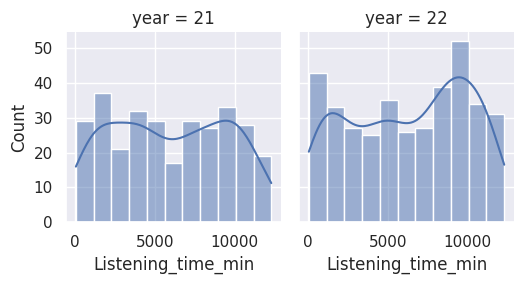

In [ ]:
''' 
Первое что хочется проверить, это активность пользователей, выраженное минутами прослушивания музыки.
Этим мы сможем взглянуть на ситуацию в целом. Если люди сталм меньше слушать, то далее необходимо будет 
уже выяснить почему. И это будет более точечная проблема, чем "почему у нас низкие продления?"
'''

# Выведем графики, отражающие количество прослушанных минут и количество людей

september_21['year'] = 21
september_22['year'] = 22
sep_two_year = pd.concat([september_21, september_22])

Listening_time_sep = sns.displot(data=sep_two_year, x="Listening_time_min", 
                                 col="year", height=3, aspect=0.9, kde=True)

# Вывод: графики не указывают на какие то явные отклонения в этом году по сравнению с предыдущим.
# Распределение по количеством минут схожее в обоих годах.
# По графикам видим только то, что в 21 году абсолютное количество людей в целом было меньше.
# Кроме того, в этом году наблюдается даже небольшой скачок тех, кто прослушивал музыку около 10 000 минут в месяц.

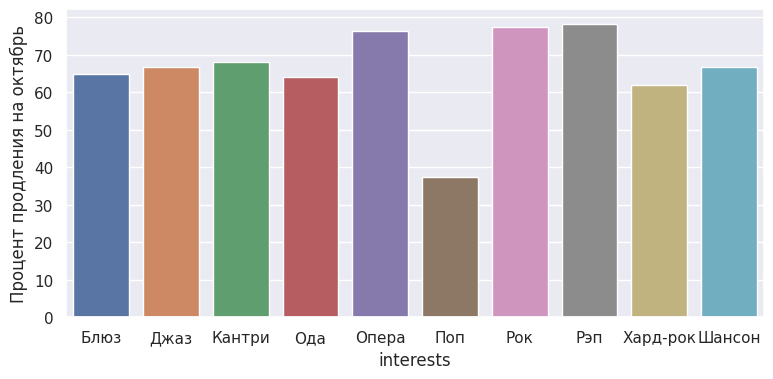

In [ ]:
'''
Далее будем выгрузку сентября 2022 года декомпозировать на продления по интересам пользователей
и любимым исполнителям. 
Гипотеза: теряем клиентов определенных интересов или любимых исполнителей.
Постараемся определить отличающиеся категории. 
'''

def prolong_interest(first_month, second_month):
  second_month['boolean_prolongation'] = 1
  prolong_interest = first_month[['id','Name','Month', 'interests']] \
                  .merge(second_month[['id','interests', 'boolean_prolongation']], \
                    on = ['id', 'interests'], how = 'left').fillna(0) \
                  .groupby(['interests'])['boolean_prolongation'] \
                  .agg(['mean', 'count', 'sum'])\
                  .reset_index().round(4)    
  prolong_interest['mean'] = prolong_interest['mean'] * 100
  prolong_interest = prolong_interest\
                  .rename(columns = {'mean': 'Процент продления на октябрь', 
                                    'count': 'Количество оплат в сентябре', 
                                    'sum': 'Количество перешедших на октябрь'})
  return prolong_interest

prolong_interest = prolong_interest(september_22, october_22)
sns.set(rc={'figure.figsize':(9, 4)})
interests_bar = sns.barplot(data=prolong_interest, 
                            x="interests", y="Процент продления на октябрь", 
                            capsize = 0.5)

# Вывод: категория любителей ПОП музыки отличилась. У них продления заметно ниже, чем в остальных жанрах.

In [ ]:
prolong_interest['Вес количества клиентов'] = \
  (prolong_interest['Количество оплат в сентябре'] / 
   prolong_interest['Количество оплат в сентябре'].sum()) * 100

prolong_interest.sort_values(by = 'Процент продления на октябрь').head()


# Как видим, общее число любителей ПОП музыки составляет 6,45%.
# Даже если бы мы потеряли всех любителей ПОП музыки в октябре, 
# продления бы не упали на 20% относительно прошлого года
# Интересы пользователей маловероятно послужили бы процентом низких продлений. 
# Никаких выбросов кроме ПОП музыки не было.
# Разве что процент упал равномерно по каждому из интересов, 
# если не обнаружим проблемы в любимых исполнителях, вернемся к этой версии/

,interests,Процент продления на октябрь,Количество оплат в сентябре,Количество перешедших на октябрь,Вес количества клиентов
5,Поп,37.50,24,9.0,6.451613
8,Хард-рок,62.07,29,18.0,7.795699
3,Ода,64.00,25,16.0,6.720430
0,Блюз,64.86,37,24.0,9.946237
1,Джаз,66.67,36,24.0,9.677419


In [ ]:
# Теперь посмотрим на любимых исполнителей пользователей

def prolong_singer(first_month, second_month):
  second_month['boolean_prolongation'] = 1
  prolong_singer = first_month[['id','Name','Month', 'favorite_singer']] \
                  .merge(second_month[['id','favorite_singer', 'boolean_prolongation']], \
                    on = ['id', 'favorite_singer'], how = 'left').fillna(0) \
                  .groupby(['favorite_singer'])['boolean_prolongation'] \
                  .agg(['mean', 'count', 'sum'])\
                  .reset_index().round(4)    
  prolong_singer['mean'] = prolong_singer['mean'] * 100
  prolong_singer = prolong_singer\
                  .rename(columns = {'mean': 'Процент продления на октябрь', 
                                    'count': 'Количество оплат в сентябре', 
                                    'sum': 'Количество перешедших на октябрь'})
  return prolong_singer

prolong_singer = prolong_singer(september_22, october_22)

prolong_singer['Вес количества клиентов'] = \
  (prolong_singer['Количество оплат в сентябре'] / 
   prolong_singer['Количество оплат в сентябре'].sum()) * 100

prolong_singer.sort_values(by = 'Процент продления на октябрь').head()

# Сразу замечаем, что у Боба Дилана нет продлений. 
# Недавно на правах интеллектуальной собственности его песни изъяли из сервиса "Звук".
# Вес любителей Боба Дилана как раз составлял почти 20% от всех. 
# Поэтому их потеря снизила и общий процент продлений на то же число.

,favorite_singer,Процент продления на октябрь,Количество оплат в сентябре,Количество перешедших на октябрь,Вес количества клиентов
0,Боб Дилан,0.00,72,0.0,19.354839
5,Элтон Джон,28.09,89,25.0,23.924731
4,Рианна,70.73,41,29.0,11.021505
1,Брайан Адамс,82.50,40,33.0,10.752688
6,Эминем,95.12,41,39.0,11.021505


#### Вывод: сервис звук потерял клиентов, которые были фанатами Боба Дилана. Его фанаты составляли 20% аудитории. Они не продлили свою подписку и общий процент продлений, соответственно, снизился на 20%.

<!-- впрар -->